# Vorhersage eines Triebwerksausfalls aufgrund von Sensormesswerten mit XGBoost

In [1]:
import h5py
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filename = '../data/N-CMAPSS_DS03-012.h5'

In [3]:
# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_train = np.array(hdf.get('W_dev'))             # W
        X_s_train = np.array(hdf.get('X_s_dev'))         # Sensors
        Y_train = np.array(hdf.get('Y_dev'))             # RUL  
        A_train = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # Sensors
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))

Der folgende Codeblock extrahiert drei Treibwerke aus dem Trainset und aus dem Testset, dies ist für das Training des ML-Modells nötig.

In [4]:
# Masks
mask_dev_units = np.isin(A_train[:,0].astype(int), [4, 5])
mask_test_units = np.isin(A_test[:,0].astype(int), [11])

# Extract chosen units
X_s_dev = np.concatenate([X_s_train[mask_dev_units], X_s_test[mask_test_units]], axis=0)
W_dev = np.concatenate([W_train[mask_dev_units], W_test[mask_test_units]], axis=0)
Y_dev = np.concatenate([Y_train[mask_dev_units], Y_test[mask_test_units]], axis=0).ravel()
A_dev = np.concatenate([A_train[mask_dev_units], A_test[mask_test_units]], axis=0)

# Remove chosen units from train and test sets
X_s_train = X_s_train[~mask_dev_units]
W_train = W_train[~mask_dev_units]
Y_train = Y_train[~mask_dev_units]
A_train = A_train[~mask_dev_units]

X_s_test = X_s_test[~mask_test_units]
W_test = W_test[~mask_test_units]
Y_test = Y_test[~mask_test_units]
A_test = A_test[~mask_test_units]

In [6]:
df_A = DataFrame(data=A_train, columns=A_var)
df_A_dev = DataFrame(data=A_dev, columns=A_var)
df_A_test = DataFrame(data=A_test, columns=A_var)
df_A.describe()


,unit,cycle,Fc,hs
count,4.631047e+06,4.631047e+06,4.631047e+06,4.631047e+06
mean,5.577160e+00,3.601043e+01,2.291261e+00,3.218762e-01
std,2.579950e+00,2.112944e+01,7.049348e-01,4.671959e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,3.000000e+00,1.800000e+01,2.000000e+00,0.000000e+00
50%,6.000000e+00,3.600000e+01,2.000000e+00,0.000000e+00
75%,8.000000e+00,5.400000e+01,3.000000e+00,1.000000e+00
max,9.000000e+00,8.400000e+01,3.000000e+00,1.000000e+00


### Unit Ids 
Mit diesem Codeabschnitt wird geschaut wie viele Triebwerke im Devset und im Testset sind.

In [16]:
print(np.unique(df_A["unit"]))
print(np.unique(df_A_dev["unit"]))
print(np.unique(df_A_test["unit"]))

[1. 2. 3. 6. 7. 8. 9.]
[ 4.  5. 11.]
[10. 12. 13. 14. 15.]


### Verfügbare Triebwerke pro Flugklasse

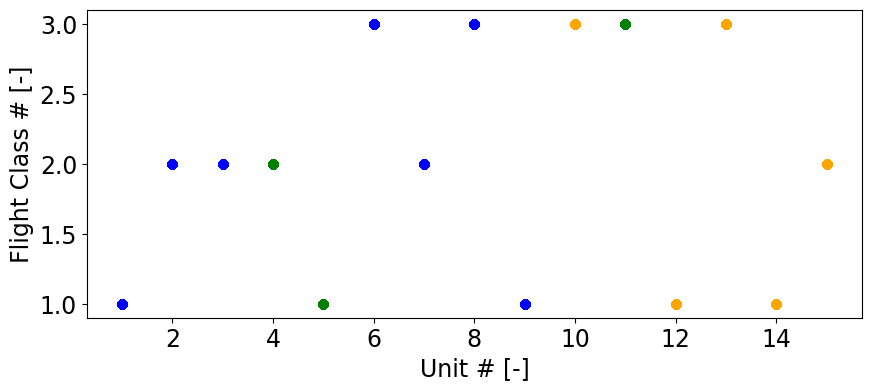

In [7]:
labelsize = 17
plt.figure(figsize=(10,4))
# trainset 
plt.plot(df_A.unit, df_A.Fc, 'o', color='Blue')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

# devset
plt.plot(df_A_dev.unit, df_A_dev.Fc, 'o', color='Green')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )

# testset
plt.plot(df_A_test.unit, df_A_test.Fc, 'o', color='Orange')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )

## Datenaufbereitung

In [8]:
# Train
fc = A_train[:, 0].reshape(-1, 1)
X_train = np.concatenate((X_s_train, fc, W_train), axis=1)
Y_train = Y_train.ravel()

# Dev
fc_dev = A_dev[:, 0].reshape(-1, 1)
X_dev = np.concatenate((X_s_dev, fc_dev, W_dev), axis=1)
Y_dev = Y_dev.ravel()

# Test
fc_test = A_test[:, 0].reshape(-1, 1)
X_test = X_s_test
X_test = np.concatenate((X_test, fc_test, W_test), axis=1)
Y_test = Y_test.ravel()

## XGBoost

In [9]:
# Import
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error

In [10]:
feature_names = (X_s_var + ["fc"] + W_var)
dtrain = xgb.DMatrix(X_train, label=Y_train, feature_names=feature_names)
ddev = xgb.DMatrix(X_dev, label=Y_dev, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=Y_test, feature_names=feature_names)

### Model Training

In [53]:
# Training parameters
params = {
    "objective": "reg:squarederror",   # regression
    "max_depth": 5,                    # tree depth
    "eta": 0.05,                       # learning rate
    "subsample": 0.8,                  # row sampling
    "colsample_bytree": 0.8,           # feature
    "gamma": 0.1,                      # require improvement to split 
    "tree_method": "hist",             # use GPU for training
    "device": "cuda",                  # use GPU
    "seed": 42
}

# Train model
num_round = 500
evallist = [(dtrain, "train"), (ddev, "eval")]

bst = xgb.train(
    params, 
    dtrain, 
    num_round, 
    evals=evallist, 
    #early_stopping_rounds=50,  # stop if no improvement
    verbose_eval=10            # print progress every 10 rounds
)

bst.save_model("../models/xgb_rul.json")

[0]	train-rmse:20.94458	eval-rmse:21.02209
[10]	train-rmse:19.80419	eval-rmse:20.63566
[20]	train-rmse:19.03988	eval-rmse:21.09414
[30]	train-rmse:18.45318	eval-rmse:21.36846
[40]	train-rmse:17.77146	eval-rmse:21.14523
[50]	train-rmse:17.19588	eval-rmse:20.81401
[60]	train-rmse:16.63688	eval-rmse:20.44266
[70]	train-rmse:16.22594	eval-rmse:20.21374
[80]	train-rmse:15.75872	eval-rmse:19.87019
[90]	train-rmse:15.39504	eval-rmse:19.62858
[100]	train-rmse:15.03223	eval-rmse:19.39807
[110]	train-rmse:14.69494	eval-rmse:19.37495
[120]	train-rmse:14.38746	eval-rmse:19.17343
[130]	train-rmse:14.06366	eval-rmse:19.13132
[140]	train-rmse:13.78976	eval-rmse:18.94556
[150]	train-rmse:13.51525	eval-rmse:18.78200
[160]	train-rmse:13.23748	eval-rmse:18.60389
[170]	train-rmse:13.02375	eval-rmse:18.48605
[180]	train-rmse:12.81833	eval-rmse:18.36079
[190]	train-rmse:12.61058	eval-rmse:18.23215
[200]	train-rmse:12.39831	eval-rmse:18.11244
[210]	train-rmse:12.21750	eval-rmse:18.00998
[220]	train-rmse:12.0

### Vorhersage

In [11]:
# Load the model
model = xgb.Booster()
model.load_model("../models/xgb_rul.json")

# Predict
Y_pred = model.predict(dtest)

### Evaluation

In [12]:
# Evaluation
rmse = root_mean_squared_error(Y_test, Y_pred)
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 15.51


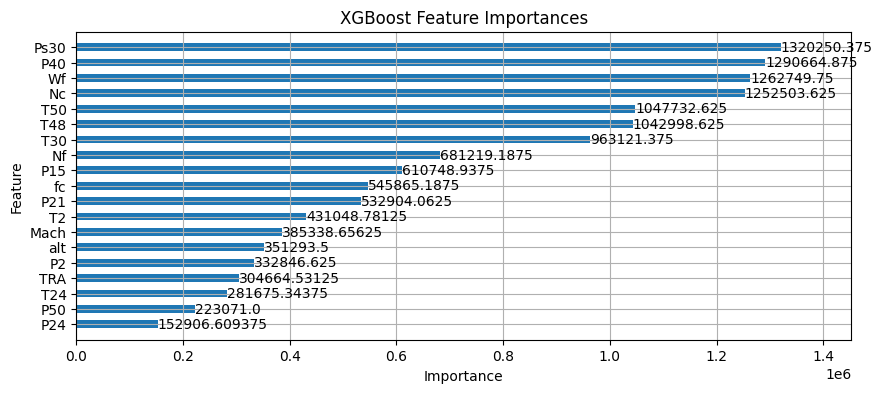

In [13]:
# Feature importances
fig, ax = plt.subplots(figsize=(10, 4))
xgb.plot_importance(model, importance_type="gain", height=0.5, ax=ax)
ax.set_ylabel("Feature")
ax.set_xlabel("Importance")
ax.set_title("XGBoost Feature Importances")
plt.show()

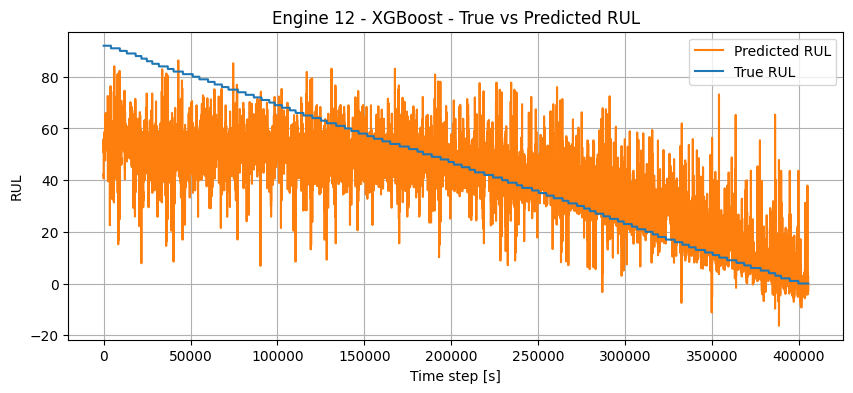

In [14]:
unit_ids_test = A_test[:, 0]
unit = 12
indices = np.where(unit_ids_test == unit)[0]

plt.figure(figsize=(10, 4))
plt.plot(Y_pred[indices], label="Predicted RUL", color='tab:orange')
plt.plot(Y_test[indices], label="True RUL", color='tab:blue')
plt.title(f"Engine {unit} - XGBoost - True vs Predicted RUL")
plt.xlabel("Time step [s]")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()